# Differentiate Walking Features between PD Patients and Controls

In [1]:
# Import a bunch of the basics

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns
#matplotlib.rcParams['savefig.dpi'] = 144

import numpy as np
import pandas as pd
import datetime
import os
import math
from binascii import hexlify

# A ton of Bokeh tools in case we want to build some pretty plots
from bokeh.embed import components, notebook_div, autoload_static
from bokeh.plotting import figure, gridplot, output_file, show, save
from bokeh.io import output_notebook, output_file, show
from bokeh.resources import INLINE, CDN
from bokeh.util.string import encode_utf8
from bokeh.models.widgets import CheckboxButtonGroup, CheckboxGroup, RadioButtonGroup, RangeSlider, RadioGroup
from bokeh.models import CustomJS, Legend, ColumnDataSource, HoverTool, Range1d, LinearColorMapper, LogColorMapper 
from bokeh.models import DatetimeTickFormatter, LabelSet, Title
from bokeh.charts import Bar, output_file, show
from bokeh.layouts import row, column,gridplot

# Models for training / testing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn import base
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Helper modules for processing the binary data files
import DataLoader
import FeatureExtractor
import Quaternions

project_path ='/Users/qiaolinchen/documents/data_incubator/capstone/rabbit_run/'
FREQ = 31  #for rabbit run data, sampling at 31/sec

In [3]:
# Import previously saved classification model for walking detection 
import dill
est_logreg  = dill.load(open('est_logreg_STD_AMAG_155.dill', 'r'))

## Read all raw data for walking part
* Files are previously saved as CSV
* Windows for computing rolling statistics are 5s (5*31 = 155) 
* Read in all left leg(LL) and right leg(RL) data
* All 20 subjects have left leg data, but 2 PD patients didn't have right leg data
* 'Walking'  is the predicted walking or not from previous classification model

In [4]:
CT_walk_LL = pd.read_csv( 'df_sig_X16-X20_LL_raw.csv' )
# create a column walking or not, using  walking classification, 1= walk, 0 = not walk
CT_walk_LL['Walking'] = est_logreg.predict(CT_walk_LL ) 
#CT_walk_LL['Walk_smooth']= CT_walk_LL['Walking'].rolling(155,  center= True , min_periods=1).mean()>= 0.5
CT_walk_LL['AMAG_FFT_ratio_1vs2'] = (CT_walk_LL['FFTP_W1_AMAG_155']/CT_walk_LL['FFTP_W2_AMAG_155']).rolling(155, center= True ,min_periods=1).mean()
CT_walk_LL.shape

(261352, 69)

In [5]:
CT_walk_RL = pd.read_csv( 'df_sig_X16-X20_RL_raw.csv' )
# create a column walking or not, using  walking classification, 1= walk, 0 = not walk
CT_walk_RL['Walking'] = est_logreg.predict(CT_walk_RL ) 
#CT_walk_RL['Walk_smooth']= CT_walk_RL['Walking'].rolling(155,  center= True , min_periods=1).mean()>= 0.5
CT_walk_RL['AMAG_FFT_ratio_1vs2'] = (CT_walk_RL['FFTP_W1_AMAG_155']/CT_walk_RL['FFTP_W2_AMAG_155']).rolling(155, center= True ,min_periods=1).mean()
CT_walk_RL.shape

(259291, 69)

In [6]:
PD_walk_LL = pd.read_csv( 'df_sig_X1-X15_LL_raw.csv' )
# create a column walking or not, using  walking classification, 1= walk, 0 = not walk
PD_walk_LL['Walking'] = est_logreg.predict(PD_walk_LL ) 
#PD_walk_LL['Walk_smooth']= PD_walk_LL['Walking'].rolling(155,  center= True , min_periods=1).mean()>= 0.5
PD_walk_LL['AMAG_FFT_ratio_1vs2'] = PD_walk_LL['FFTP_W1_AMAG_155']/PD_walk_LL['FFTP_W2_AMAG_155'].rolling(155, center= True  ,min_periods=1).mean()
PD_walk_LL.shape

(721064, 69)

In [7]:
PD_walk_RL = pd.read_csv( 'df_sig_X1-X15_RL_raw.csv' )
# create a column walking or not, using  walking classification, 1= walk, 0 = not walk
PD_walk_RL['Walking'] = est_logreg.predict(PD_walk_RL ) 
#PD_walk_RL['Walk_smooth']= PD_walk_RL['Walking'].rolling(155,  center= True , min_periods=1).mean()>= 0.5
PD_walk_RL['AMAG_FFT_ratio_1vs2'] = PD_walk_RL['FFTP_W1_AMAG_155']/PD_walk_RL['FFTP_W2_AMAG_155'].rolling(155, center= True  ,min_periods=1).mean()
PD_walk_RL.shape

(624380, 69)

### Visualize Acceleration Maginitude (AMAG) and XY Angle in data

In [253]:
# Make a timeseries plot
def make_plots( df , lo=-1 , hi=-1 ):
    df2= df
    df2.reset_index()
    if lo < 0: lo = 0
    if hi < 1: hi = len(df)
    for f in ['AMAG','XYANGLE']:
        fig, ax = plt.subplots( figsize=(16,4) )
        ax.plot( df2['Walking' ].index , df2['Walking' ] ,   linewidth= 2  )
        #ax.plot( df2['Walk_smooth' ].index , df2['Walk_smooth' ] ,   linewidth= 2  )
        for subj in list(set(df2['SUBJECT'])):
            ax.plot( df2.loc[df2['SUBJECT']== subj,f ].index , df2.loc[df2['SUBJECT']== subj,f ] , 
                    linewidth=0.5 ,label= subj)

        plt.legend(bbox_to_anchor=(1.05, 1), loc= 0, borderaxespad=0.)    
        ax.set_xlabel( 'IDX' )
        ax.set_ylabel( f )
    
    #del df2

#### Left leg of 15 patients - Drop down of the blue line indicate non-walking period

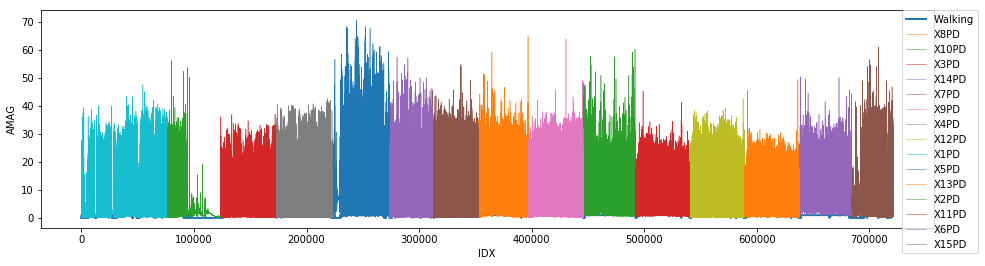

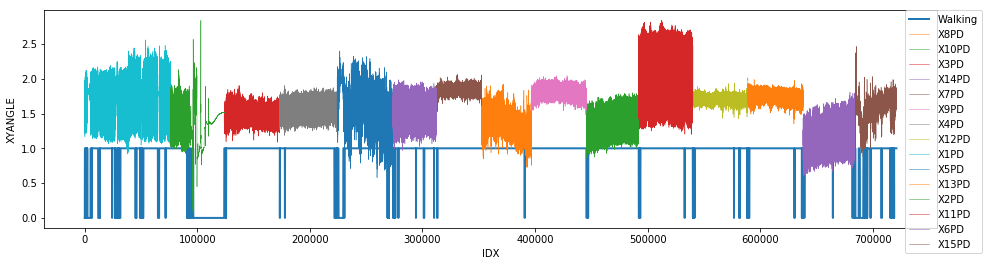

In [254]:
make_plots(PD_walk_LL)

#### Right leg of 13 patients

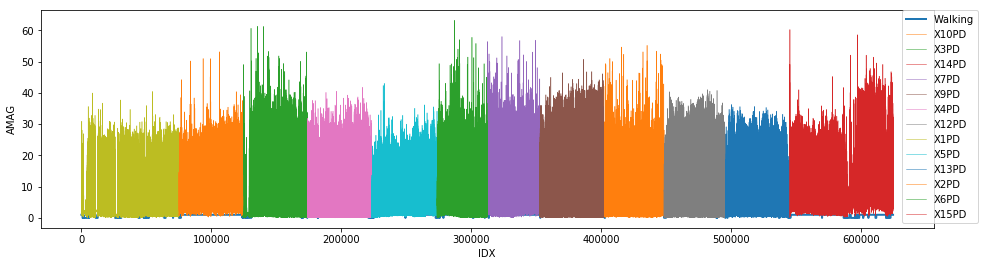

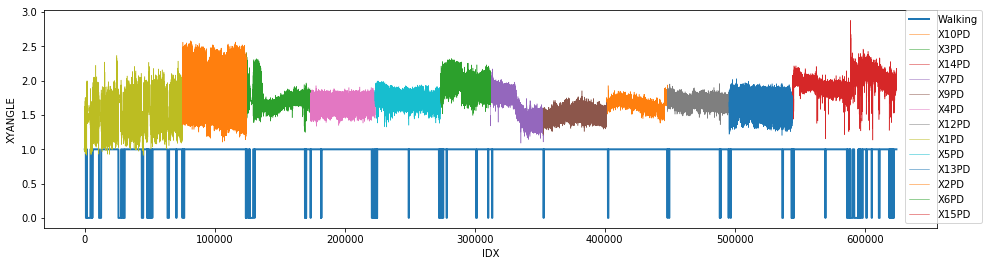

In [255]:
make_plots(PD_walk_RL)

#### manually exam the plot and cut out the parts when subject was not walking
```python
def cut( df , lo , hi ):
    df = df.drop( labels=range(lo,hi) , axis=0 )
    df.index = range(len(df))
    print df.shape
    return df

PD_walk1 = cut( PD_walk , 92000 , 124000 )
PD_walk1 = cut( PD_walk1 , 193000 , 197500 )
make_plots(PD_walk1 )
```

#### Left eg of 5 controls

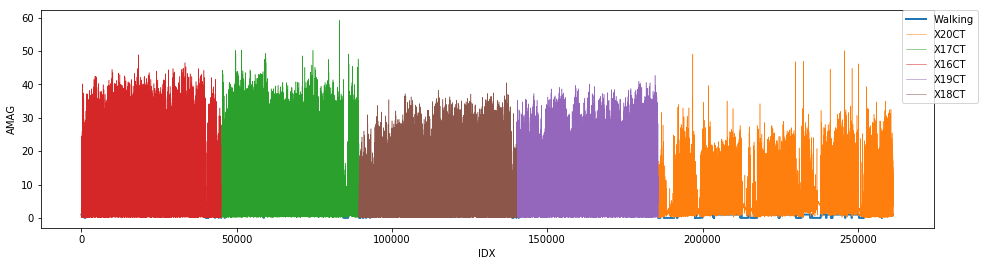

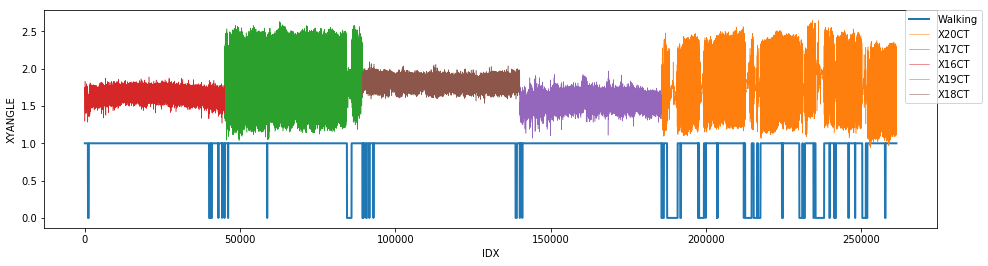

In [256]:
make_plots(CT_walk_LL)

#### Right eg of 5 controls

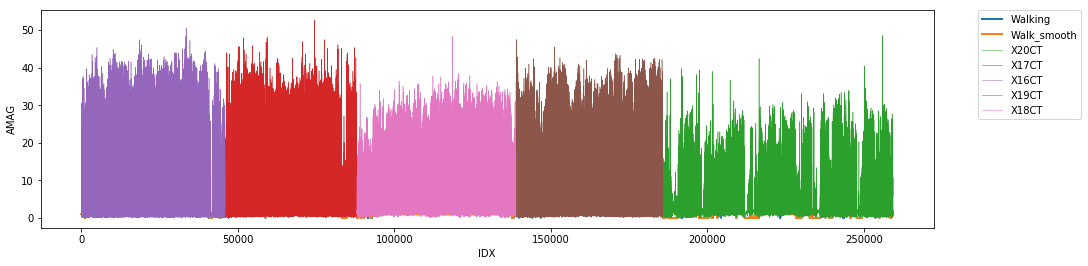

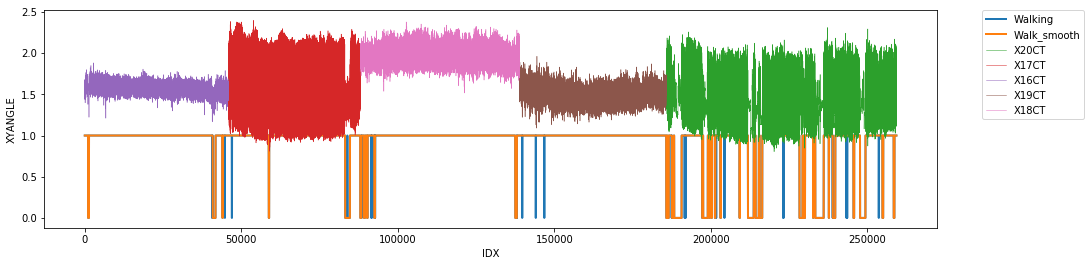

In [15]:
make_plots(CT_walk_RL)

## Compare right and left legs on key features, by subject

### Define functions to plot for patients and controls, respetively

In [8]:
def PD_LL_vs_RL(feature): 
    for subject in ['X1','X2','X3','X4','X5','X6','X7', 'X9','X10',  'X12','X13','X14','X15']:
        subj = subject + 'PD' 
        walk_LL = PD_walk_LL[PD_walk_LL['SUBJECT'] == subj]
        walk_RL = PD_walk_RL[PD_walk_RL['SUBJECT'] == subj]
        #print(len(walk_LL),len(walk_RL) )
        plt.figure(figsize=(18,5))

        plt.plot(walk_LL['T'], walk_LL[feature], label=subj + '_LL_'+ feature,alpha=0.7)
        plt.plot(walk_RL['T'], walk_RL[feature], label=subj + '_RL_'+ feature,alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc= 1, borderaxespad=0.)
    

In [9]:
def CT_LL_vs_RL(feature): 
    for subject in ['X16','X17','X18', 'X19','X20']:
        subj = subject + 'CT' 
        walk_LL = CT_walk_LL[CT_walk_LL['SUBJECT'] == subj]
        walk_RL = CT_walk_RL[CT_walk_RL['SUBJECT'] == subj]
        #print(len(walk_LL),len(walk_RL) )
        plt.figure(figsize=(18,5))

        plt.plot(walk_LL['T'], walk_LL[feature], label=subj + '_LL_'+ feature,alpha=0.7)
        plt.plot(walk_RL['T'], walk_RL[feature], label=subj + '_RL_'+ feature,alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc= 1, borderaxespad=0.)

### Compare AMAG
* Orange lines: left leg data
* Blue lines: right leg data
* We already know that clocks on different limbs were not synchronized.
* So instead of timestamp, I plot agains time T, which is the time in second from start of data collection (31 data points/sec), which is slightly better than timestamp.  For some subjects, we can manully cut and adjust time to align. 
* There are indeed time difference between limbs for some patients. We can see the lag. 

### Interesting finding:
* Clearly for X1, X3 and X9, the maximum AMAG is larger in one leg. 
* X2, X9 and X13, one leg was slightly different from the other
* In contrast, for controls, almost no difference AMAG between legs

### This is consistent with the gait asymmetry in patients with Parkinson's
* Could be used to differentiate patients and controls

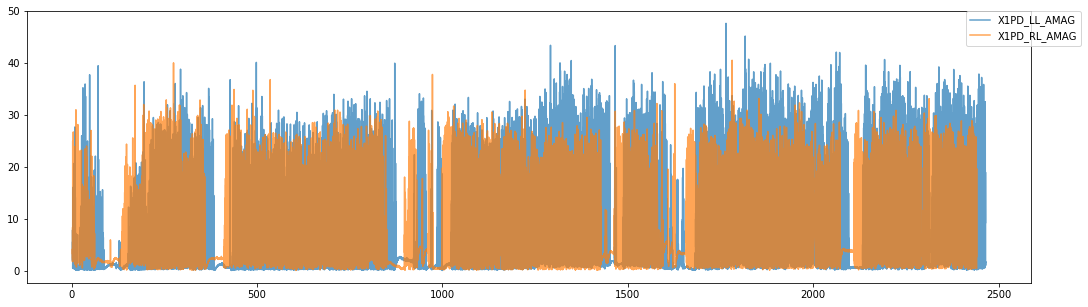

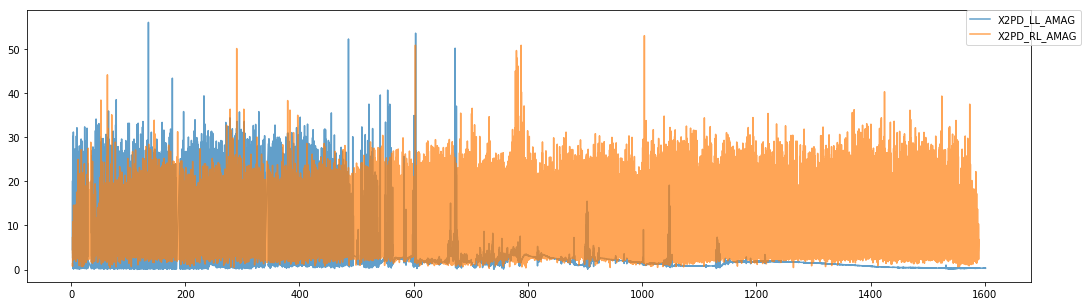

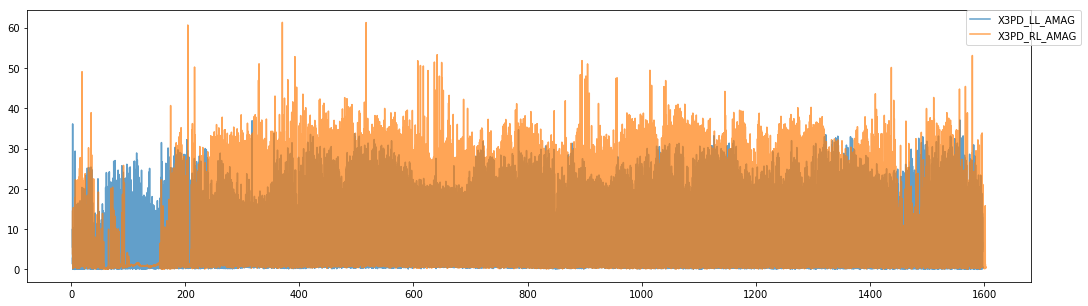

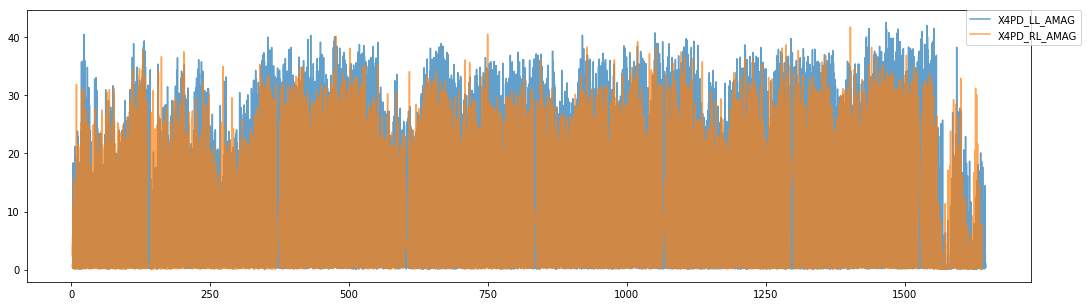

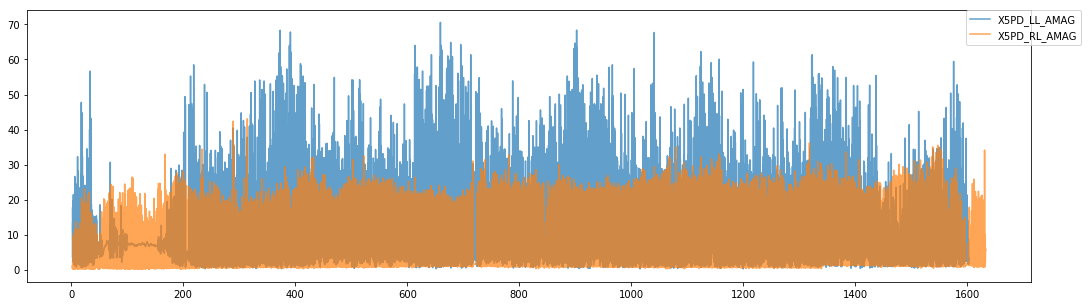

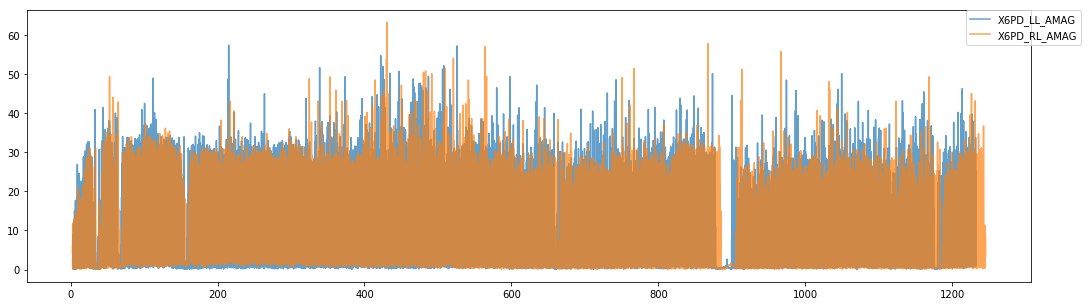

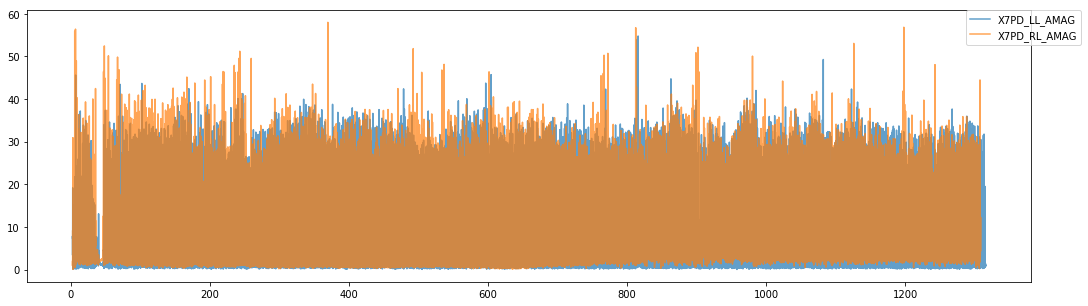

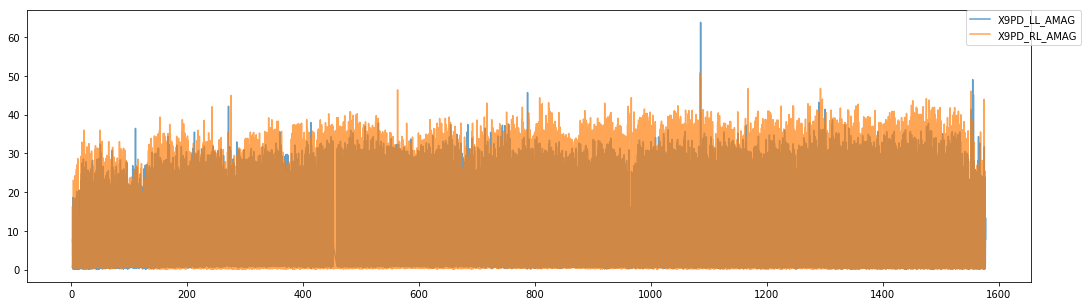

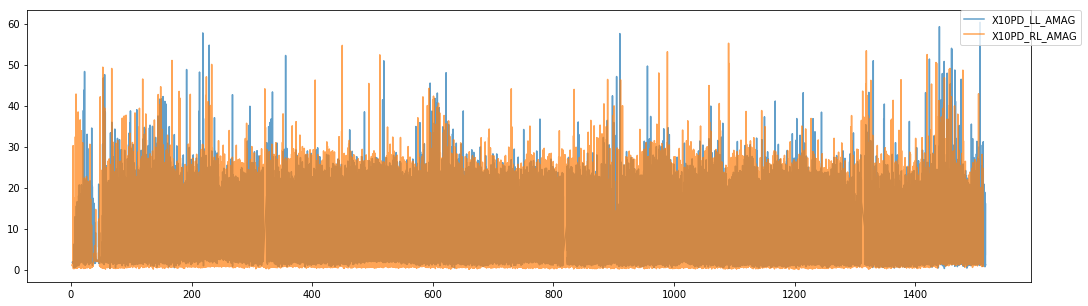

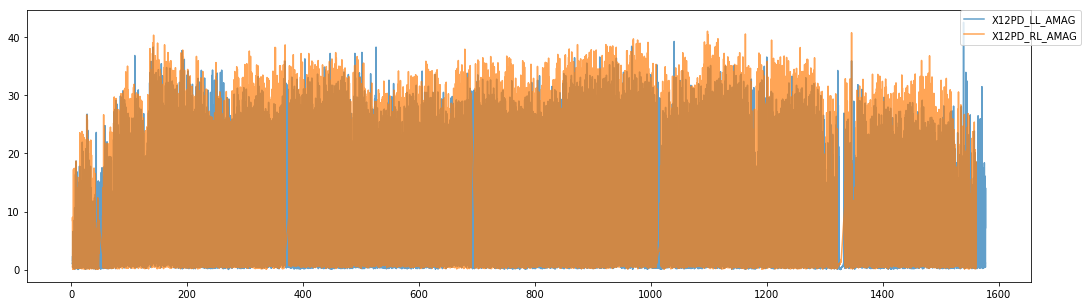

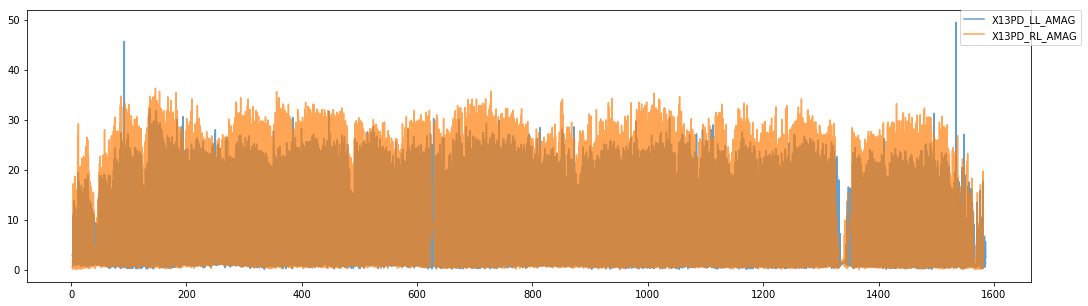

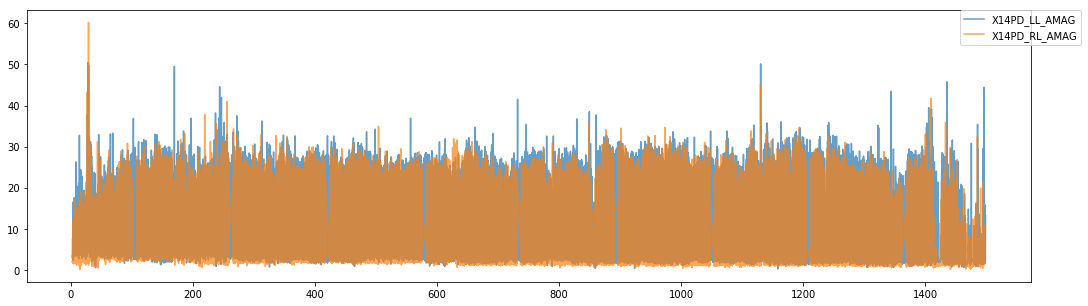

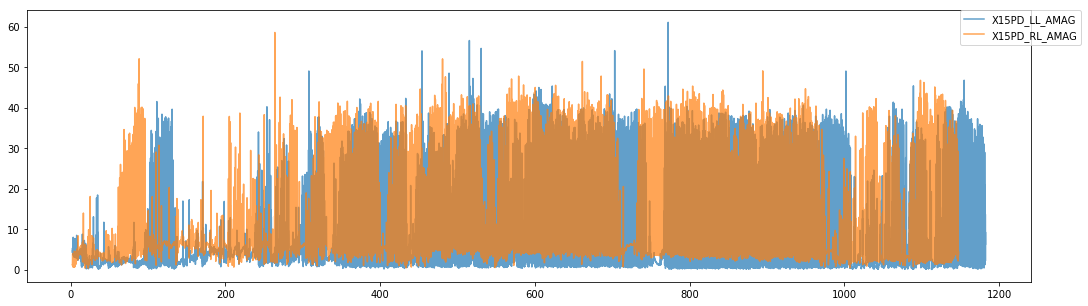

In [55]:
PD_LL_vs_RL('AMAG')
    

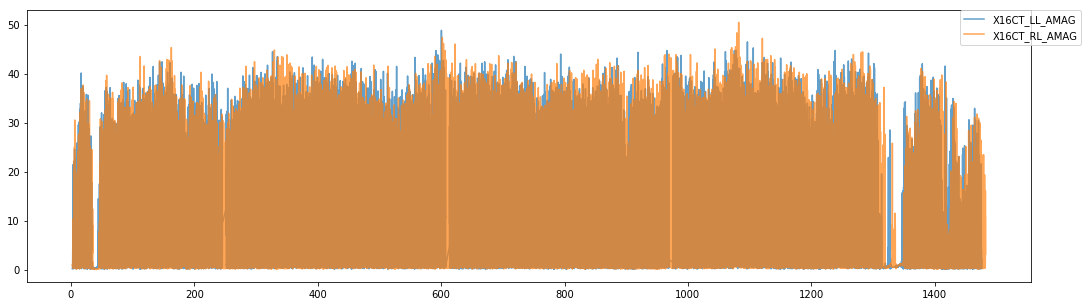

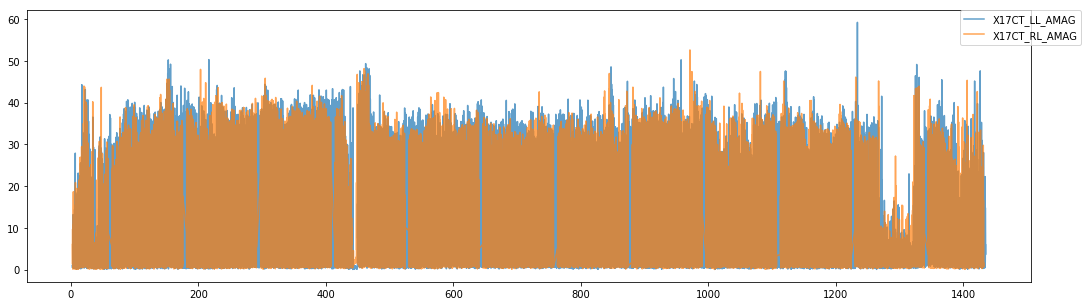

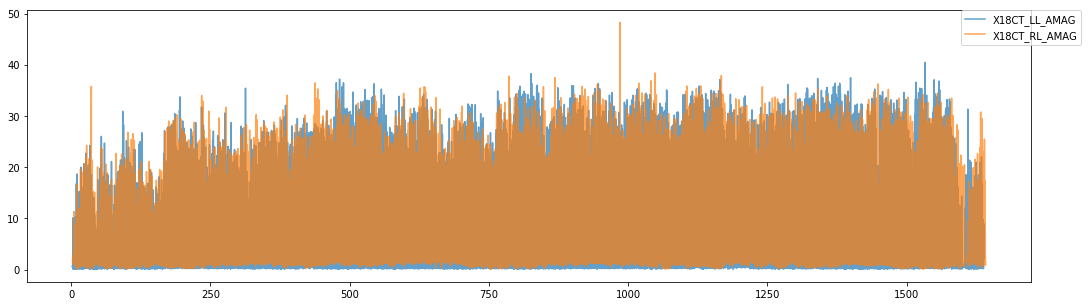

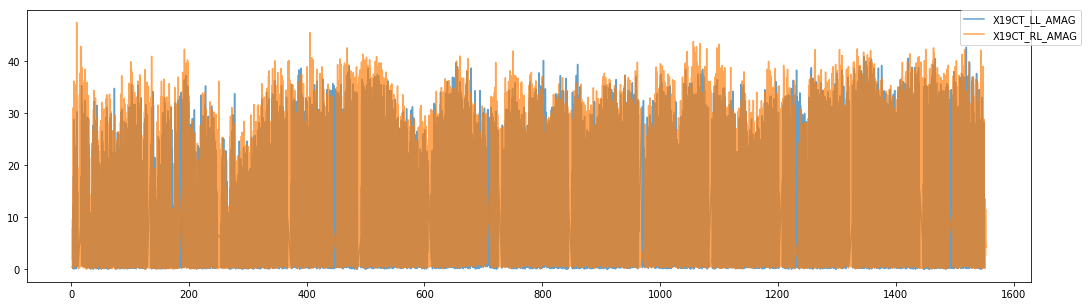

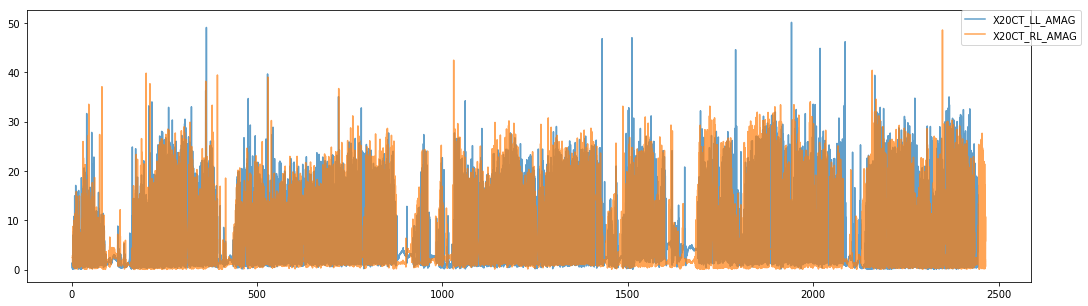

In [56]:
CT_LL_vs_RL('AMAG')

### Further look at range of AMAG
* Acceleration magnitude is positive, so when averaging over 5 sec, maximum is very likely the same as range. Both should correlated with STD.
* I look at both range and STD(standard deviation), the pattern is very simialr, but STD is less noisy, so STD is plotted below. 

### Findings:
* Consistent with speculation above, we can see the difference in STD of AMAG between legs in patients, but not in controls. 
* Patients 1,2,3,5 show asymmetry in legs.
* when interpreting plots, need to adjust for the time lag (in brain...)


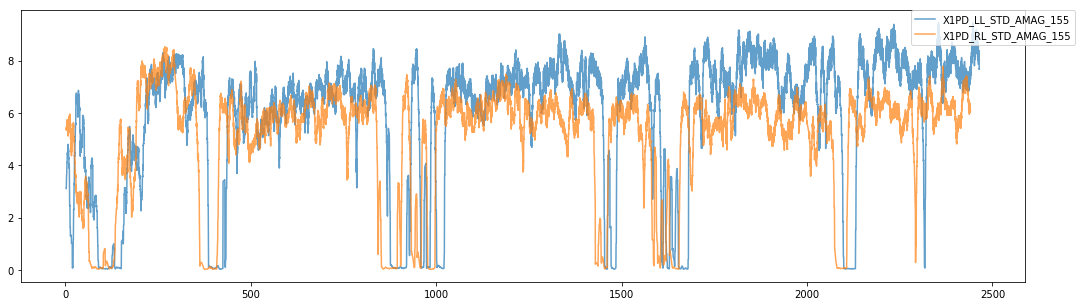

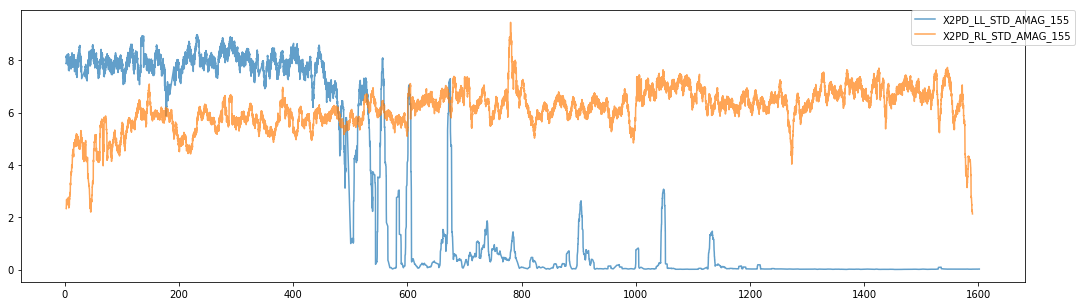

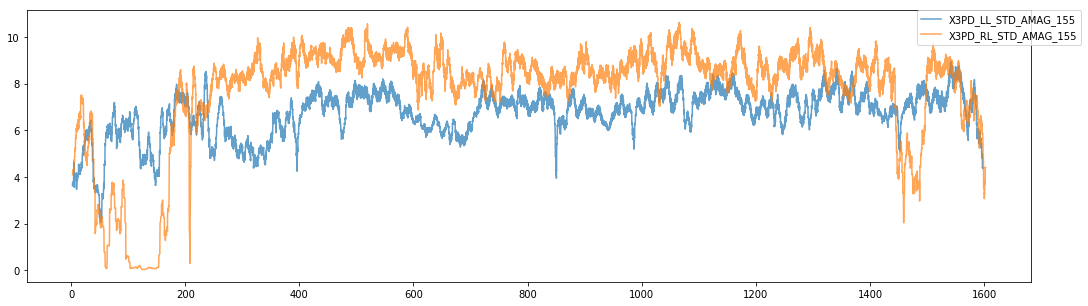

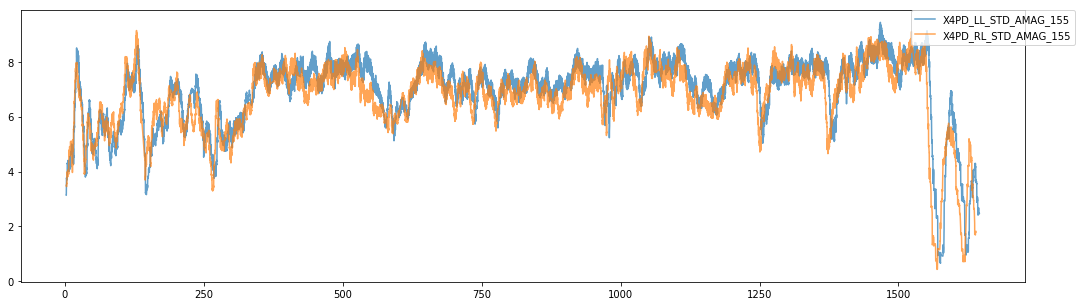

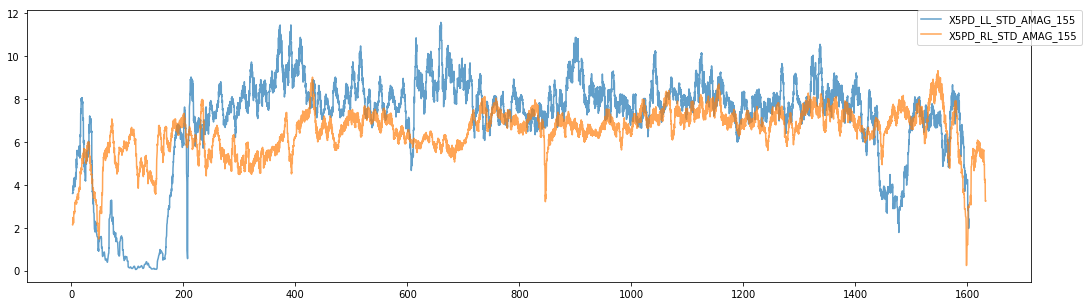

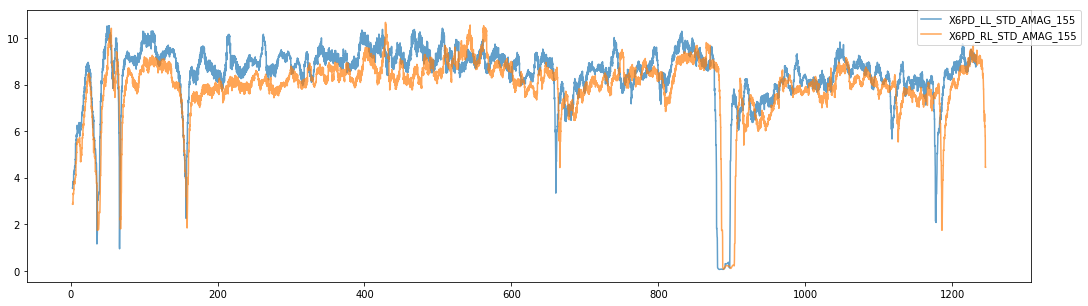

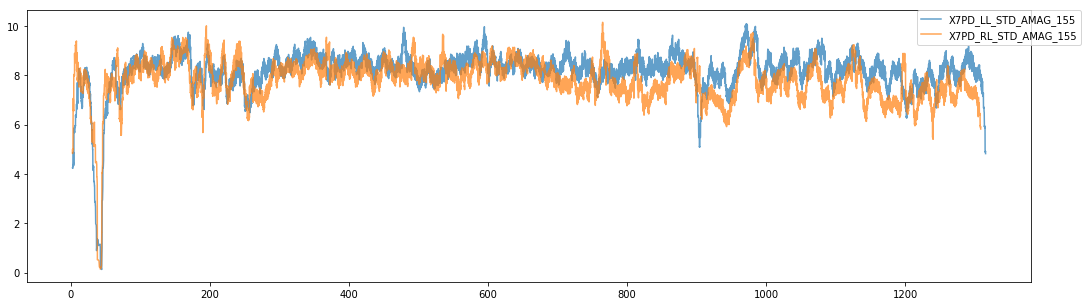

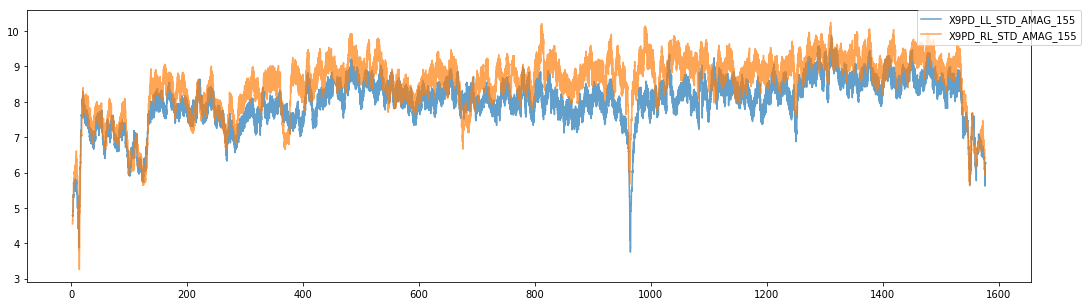

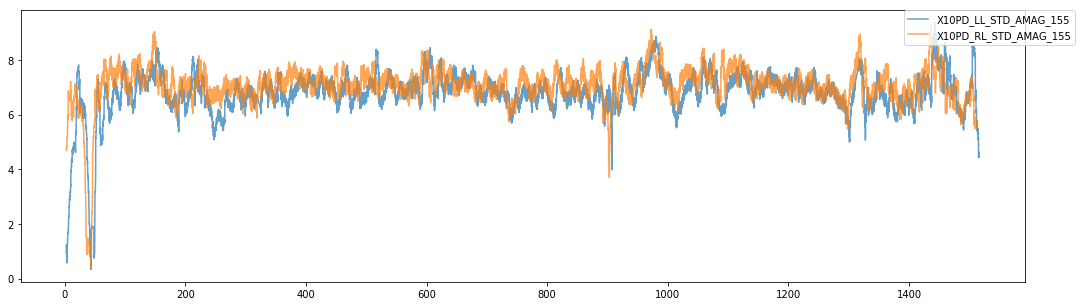

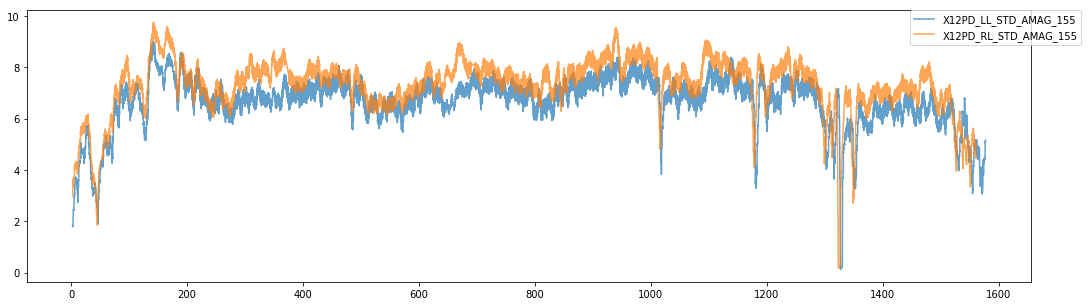

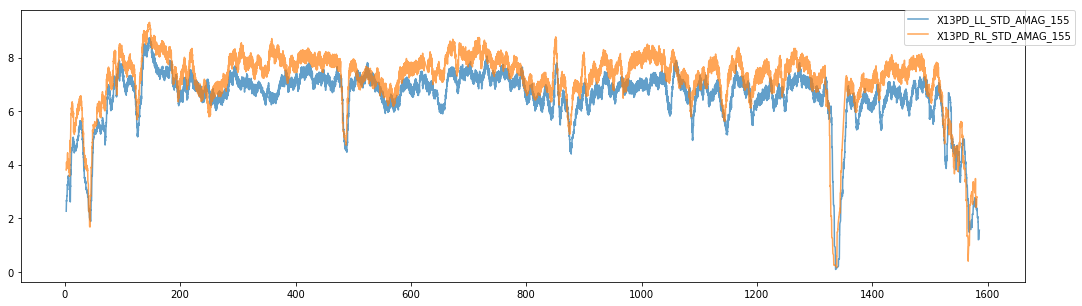

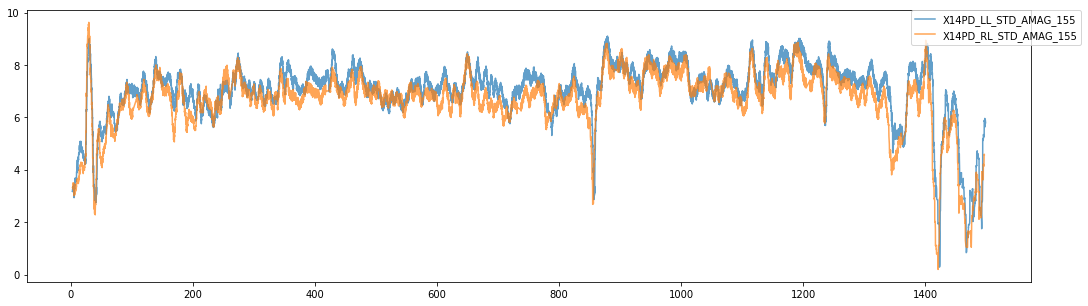

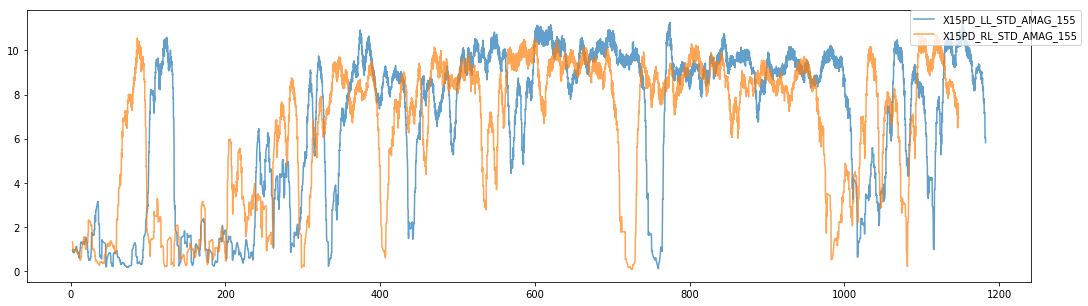

In [59]:
PD_LL_vs_RL('STD_AMAG_155')

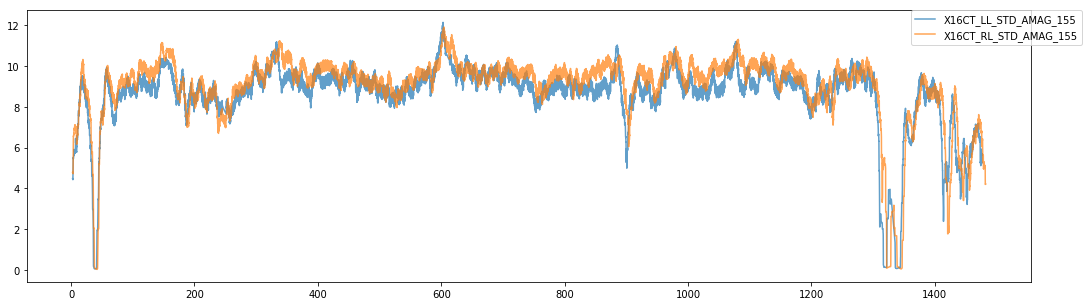

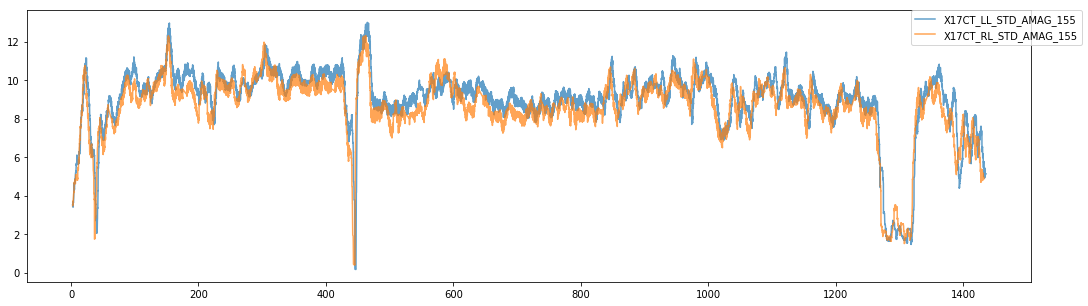

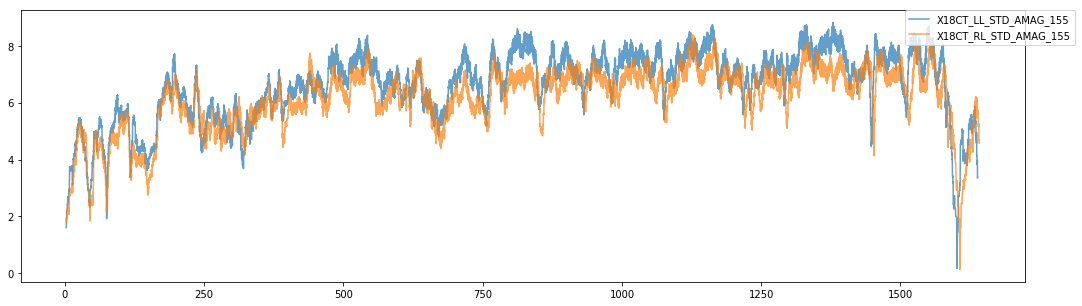

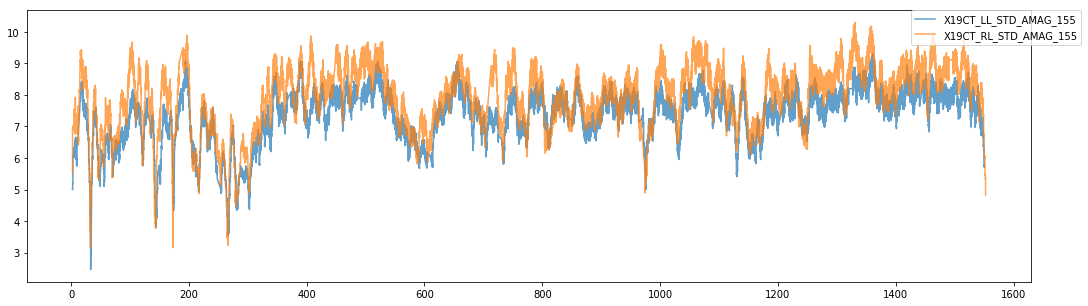

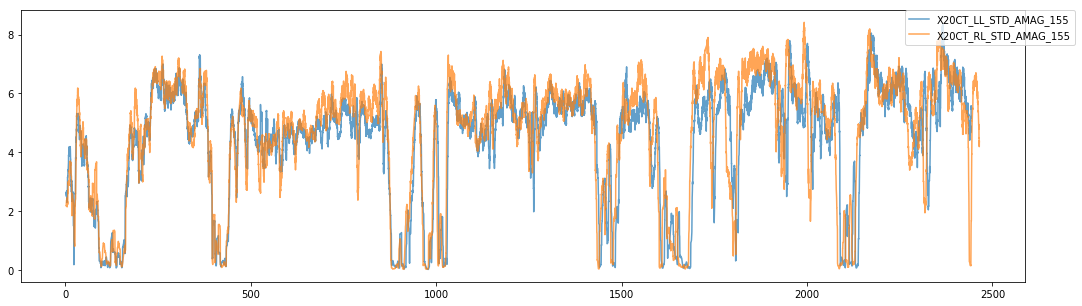

In [60]:
CT_LL_vs_RL('STD_AMAG_155')

### Attempt to identify in to Freeze of Gait in PD patients. 
* Some literatures mentioned gait analysis to differentiate parkinson's patients from controls, but the methods are too complicated
* One paper specifically mentioned that before freeze of gait, the power of 0.5-3HZ band will increase, while the power of 3-8HZ band will decrease. after start of freeze of gait, the power of 0.5-3HZ band will derease, while the power of 3-8HZ band will increase. And they use this to identify freeze of gait
* I examine several patients but did not see anything significant

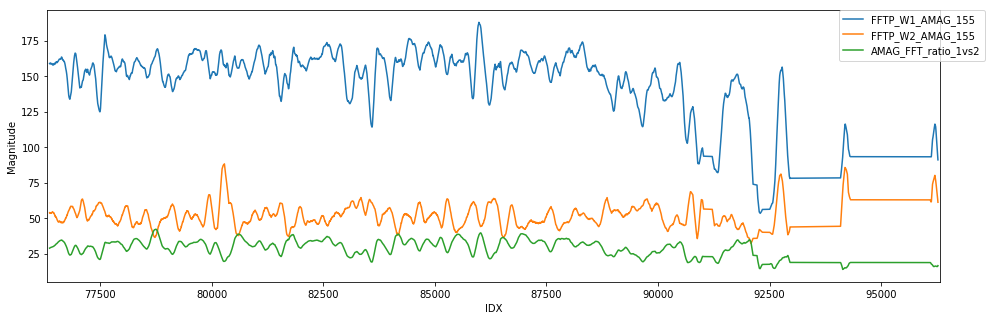

In [336]:
N = 100

df= walk[walk['Walking']==1 ]
#df= walk
#df.loc[:,'FFTP_W0_AMAG_155'].rolling(N).mean().plot()
df.loc[:,'FFTP_W1_AMAG_155'].rolling(N, center= True ).mean().plot(figsize=(16,5))
df.loc[:,'FFTP_W2_AMAG_155'].rolling(N, center= True).mean().plot()
#df.loc[: ,'FFTP_W3_AMAG_155'].rolling(N, center= True).mean().plot()
(df.loc[: ,'AMAG_FFT_ratio_1vs2']*10).rolling(N, center= True).mean().plot()



plt.legend(bbox_to_anchor=(1.05, 1), loc= 1, borderaxespad=0.)    
plt.xlabel( 'IDX' )
plt.ylabel( 'Magnitude' )

### Change subject ID to view the AX, AY AZ,  range and STD of AMAG of all patients.
* Walking patterns are indeed very different from person to person
* Drop in orange line show the predicted non-walking period 

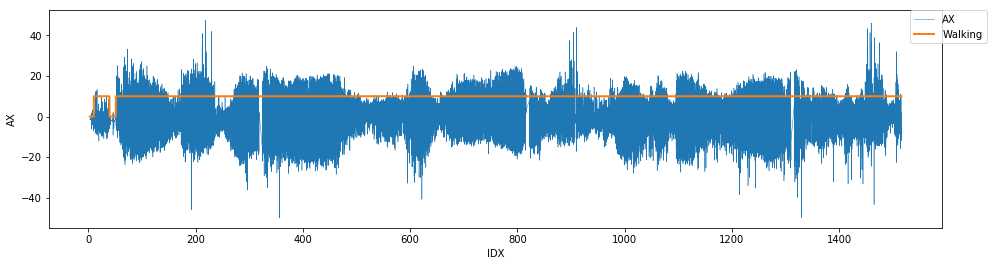

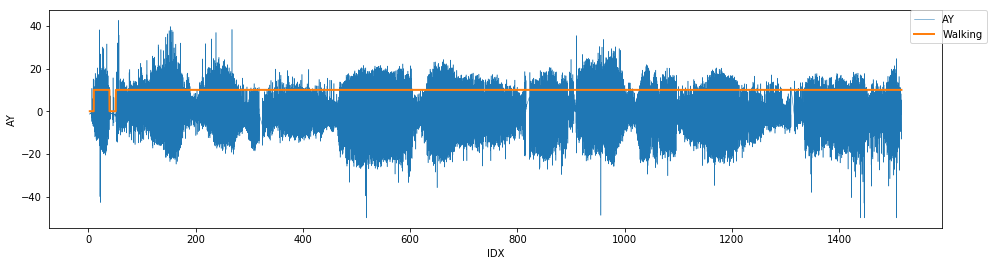

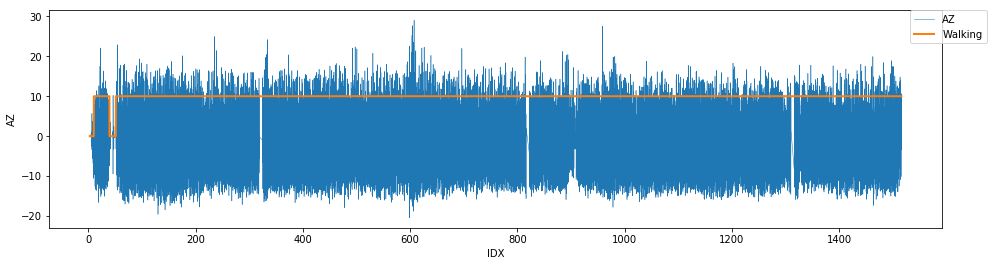

In [260]:
subject = 'X10PD'
data= PD_walk_LL.loc[PD_walk_LL['SUBJECT']==subject]
#data= CT_walk.loc[CT_walk['SUBJECT']=='X20CT']

for f in ['AX','AY','AZ']:
    fig, ax = plt.subplots( figsize=(16,4) )
    ax.plot( data['T'] , data[f]  ,   linewidth= 0.5  )
    ax.plot( data['T'] , data['Walking']*10 ,   linewidth= 2  )
    plt.legend(bbox_to_anchor=(1.05, 1), loc= 0, borderaxespad=0.)    
    ax.set_xlabel( 'IDX' )
    ax.set_ylabel( f )



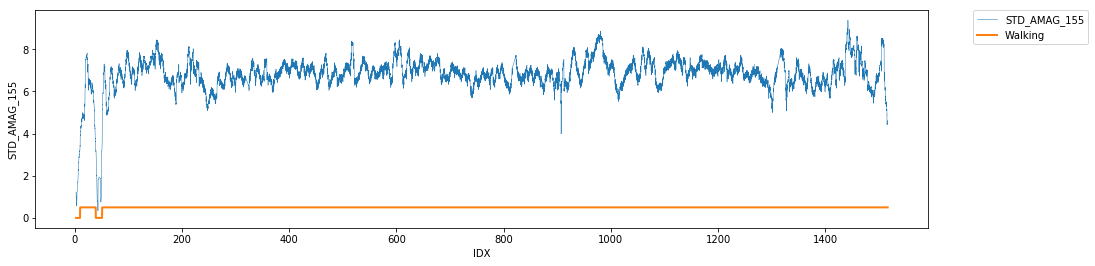

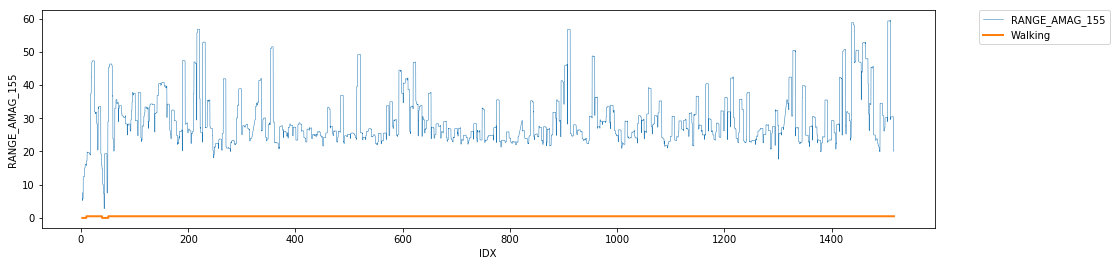

In [263]:
data= PD_walk_LL.loc[PD_walk_LL['SUBJECT']=='X10PD']
#data= CT_walk.loc[CT_walk['SUBJECT']=='X20CT']

for f in [ u'STD_AMAG_155', u'RANGE_AMAG_155']:
    fig, ax = plt.subplots( figsize=(16,4) )
    ax.plot( data['T'] , data[f]  ,   linewidth= 0.5  )
    ax.plot( data['T'] , data['Walking'] *0.5,   linewidth= 2  )
    plt.legend(bbox_to_anchor=(1.05, 1), loc= 0, borderaxespad=0.)    
    ax.set_xlabel( 'IDX' )
    ax.set_ylabel( f )



## Plot Overall Mean of Features
### 1.  For selected features, compute one overall mean for each patient


In [10]:
feat_list= ['SUBJECT','STD_AMAG_155', 'RANGE_AMAG_155', 'FFTP_W0_AMAG_155','FFTP_W1_AMAG_155',
                       'FFTP_W2_AMAG_155','FFTP_W3_AMAG_155','AMAG_FFT_ratio_1vs2']

In [13]:
PD_win_mean_LL = PD_walk_LL.loc[PD_walk_LL['Walking']==1 ,feat_list].groupby('SUBJECT').mean()
PD_win_mean_LL['TYPE'] = 'PD'
PD_win_mean_LL['LIMB'] = 'LL'
PD_win_mean_LL['TYPE_LIMB'] = 'PD_LL'

PD_win_mean_RL = PD_walk_RL.loc[PD_walk_RL['Walking']==1 ,feat_list].groupby('SUBJECT').mean()
PD_win_mean_RL['TYPE'] = 'PD'
PD_win_mean_RL['LIMB'] = 'RL'
PD_win_mean_RL['TYPE_LIMB'] = 'PD_RL'

CT_win_mean_LL = CT_walk_LL.loc[CT_walk_LL['Walking']==1 ,feat_list].groupby('SUBJECT').mean()
CT_win_mean_LL['TYPE'] = 'CT'
CT_win_mean_LL['LIMB'] = 'LL'
CT_win_mean_LL['TYPE_LIMB'] = 'CT_LL'

CT_win_mean_RL = CT_walk_RL.loc[CT_walk_RL['Walking']==1 ,feat_list].groupby('SUBJECT').mean()
CT_win_mean_RL['TYPE'] = 'CT'
CT_win_mean_RL['LIMB'] = 'RL'
CT_win_mean_RL['TYPE_LIMB'] = 'CT_RL'

window_mean = pd.concat([PD_win_mean_LL, PD_win_mean_RL, CT_win_mean_LL, CT_win_mean_RL])
window_mean['SUBJECT'] = list(window_mean.index)
window_mean.columns = [u'STD_AMAG', u'RANGE_AMAG', u'FFTP_W0_AMAG',
       u'FFTP_W1_AMAG', u'FFTP_W2_AMAG', u'FFTP_W3_AMAG',
       u'AMAG_FFT_ratio', u'TYPE', u'LIMB', u'TYPE_LIMB', u'SUBJECT']

In [14]:
window_mean = window_mean.sort_values(by= 'SUBJECT')
window_mean.head()

,STD_AMAG,RANGE_AMAG,FFTP_W0_AMAG,FFTP_W1_AMAG,FFTP_W2_AMAG,FFTP_W3_AMAG,AMAG_FFT_ratio,TYPE,LIMB,TYPE_LIMB,SUBJECT
SUBJECT,,,,,,,,,,,
X10PD,6.887994,29.891136,49.956707,138.062975,56.199325,28.690846,2.502542,PD,LL,PD_LL,X10PD
X10PD,7.146314,32.090891,49.946012,146.195726,57.272971,27.058472,2.608791,PD,RL,PD_RL,X10PD
X11PD,6.259991,24.890071,46.550563,139.474742,40.802337,27.549949,3.445065,PD,LL,PD_LL,X11PD
X12PD,6.739748,30.261754,55.442761,139.930135,41.871943,36.840989,3.403872,PD,LL,PD_LL,X12PD
X12PD,7.362743,33.218719,56.955052,146.525298,56.327174,31.061870,2.627366,PD,RL,PD_RL,X12PD


### 2. Plot AMAG frequency features - one dot per leg of patient
* This is still part of the attempt to identify patterns related to freeze of gait
* I don't see anything specific, except the variances of features are generally larger in patients, but that can be due to large number of patient( n=15) than controls(n=5)
* Maybe physicians can have more input as how to interpret these plots

In [19]:
from bokeh.charts import Scatter, output_file, show
output_notebook()
TOOLS="hover, pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
tooltips=[
    ('SUBJECT', '@SUBJECT'),
    ('LIMB', '@LIMB'),
]

p1 = Scatter(window_mean, x='FFTP_W2_AMAG', y='FFTP_W1_AMAG', color='TYPE' ,marker='LIMB',
            title="AMAG 0.5-3Hz vs AMAG 3-8Hz",
            xlabel="AMAG 3-8Hz" , ylabel="AMAG 0.5-3Hz" ,tooltips=tooltips, height= 300, width= 700)

tooltips2=[
    ('SUBJECT', '@SUBJECT'),
    ('LIMB', '@LIMB'),
]

p2 = Scatter(window_mean, x='FFTP_W2_AMAG', y='AMAG_FFT_ratio', color='TYPE',marker='LIMB', x_range=p1.x_range,
            title="AMAG 3-8Hz vs Ratio AMAG_3-8Hz / AMAG_0.4-3Hz", legend= None,
            xlabel="AMAG 3-8Hz", ylabel="Ratio AMAG_3-8Hz / AMAG_0.4-3Hz",tooltips=tooltips2, height= 300, width= 700)

tooltips3=[
    ('SUBJECT', '@SUBJECT'),
]

p3 = Scatter(window_mean, x='FFTP_W2_AMAG', y='FFTP_W3_AMAG', color='TYPE',marker='LIMB', x_range=p1.x_range,
            title="AMAG 3-8Hz vs AMAG 8-16Hz",legend= None,
            xlabel="AMAG 3-8Hz", ylabel="AMAG 8-16Hz",tooltips=tooltips3, height= 300, width= 700)

show(column(p1,p2,p3))

Loading BokehJS ...

## Match Overall Means of Right Leg and Leg Leg
* Continue our interest in examine differences between legs.
* It's natrual to think that STD and RANGE of AMAG might help to clasify patients vs control.
* Can only plot data for patients who had data in both legs

### 1. Compute data needed 
Merge the left and right leg data for the same patient.
* One row per patients, RL data first, LL data followed

In [16]:
window_mean_LL = window_mean[window_mean['LIMB']=='LL'].drop(['LIMB','TYPE_LIMB'], axis=1 )
limb= 'LL'
window_mean_LL.columns =[u'STD_AMAG' +'_'+limb, u'RANGE_AMAG'+'_'+limb, u'FFTP_W0_AMAG'+'_'+limb, 
                         u'FFTP_W1_AMAG'+'_'+limb,  u'FFTP_W2_AMAG'+'_'+limb, u'FFTP_W3_AMAG'+'_'+limb, 
                         u'AMAG_FFT_ratio'+'_'+limb,  u'TYPE' , u'SUBJECT']

window_mean_RL = window_mean[window_mean['LIMB']=='RL'].drop(['LIMB','TYPE','TYPE_LIMB','SUBJECT'], axis=1)
limb= 'RL'
window_mean_RL.columns =[u'STD_AMAG' +'_'+limb, u'RANGE_AMAG'+'_'+limb, u'FFTP_W0_AMAG'+'_'+limb, 
                         u'FFTP_W1_AMAG'+'_'+limb,  u'FFTP_W2_AMAG'+'_'+limb, u'FFTP_W3_AMAG'+'_'+limb, 
                         u'AMAG_FFT_ratio'+'_'+limb ]

window_RL_LL = pd.concat([window_mean_RL, window_mean_LL], axis=1, join='inner')

window_RL_LL.head()

,STD_AMAG_RL,RANGE_AMAG_RL,FFTP_W0_AMAG_RL,FFTP_W1_AMAG_RL,FFTP_W2_AMAG_RL,FFTP_W3_AMAG_RL,AMAG_FFT_ratio_RL,STD_AMAG_LL,RANGE_AMAG_LL,FFTP_W0_AMAG_LL,FFTP_W1_AMAG_LL,FFTP_W2_AMAG_LL,FFTP_W3_AMAG_LL,AMAG_FFT_ratio_LL,TYPE,SUBJECT
SUBJECT,,,,,,,,,,,,,,,,
X10PD,7.146314,32.090891,49.946012,146.195726,57.272971,27.058472,2.608791,6.887994,29.891136,49.956707,138.062975,56.199325,28.690846,2.502542,PD,X10PD
X12PD,7.362743,33.218719,56.955052,146.525298,56.327174,31.061870,2.627366,6.739748,30.261754,55.442761,139.930135,41.871943,36.840989,3.403872,PD,X12PD
X13PD,7.325944,29.210238,60.041751,151.099020,53.027782,25.308360,2.873100,6.687408,24.295015,54.538924,141.025184,39.021275,29.700904,3.646280,PD,X13PD
X14PD,6.798284,26.962459,48.875133,133.094904,56.188304,32.354183,2.383778,7.148765,28.520807,52.960108,135.146021,63.786324,29.157749,2.131120,PD,X14PD
X15PD,8.066915,36.978564,80.467120,150.934146,76.934588,29.592679,2.011187,8.499451,36.765043,85.673469,157.586003,80.867428,31.318961,1.983523,PD,X15PD


### 2. For each feature, plot left leg vs. right leg
* Each dot represent 1 subject
* Patient in green, control in red
* These plots are consistent with findings in trace plots above. 
* From the top two plots of STD and RANGE of AMAG, we can identify points away from the diagnal line, which are the same subjects showing assymetry in AMAG above (X3,X5, X2, X9)
* Controls in general lies very close to the diagnoal line, suggesting no obvious difference between legs. 


In [20]:
from bokeh.charts import Scatter, output_file, show
#output_file("plot_asymmetry.html")
output_notebook()
TOOLS="hover, pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
tooltips=[
    ('SUBJECT', '@SUBJECT')]

p1 = Scatter(window_RL_LL , x='FFTP_W1_AMAG_LL', y='FFTP_W1_AMAG_RL', color='TYPE' ,marker='SUBJECT',
            title="AMAG 0.5-3 Hz LL vs RL", legend=None , 
            xlabel="LL" , ylabel="RL" ,tooltips=tooltips, height= 300, width= 400)


p1.line(x=[0,1000], y=[0,1000], line_color="#666699", line_width=2)

#plot.line(r_x, r_y, color="red")

p2 = Scatter(window_RL_LL , x='FFTP_W2_AMAG_LL', y='FFTP_W2_AMAG_RL', color='TYPE' ,marker='SUBJECT',
            title="AMAG 3-8 Hz LL vs RL", legend=None , 
            xlabel="LL" , ylabel="RL" ,tooltips=tooltips, height= 300, width= 400)

p2.line(x=[0,1000], y=[0,1000], line_color="#666699", line_width=2)


p3 = Scatter(window_RL_LL , x='FFTP_W3_AMAG_LL', y='FFTP_W3_AMAG_RL', color='TYPE' ,marker='SUBJECT',
            title="AMAG 8-16 Hz LL vs RL", legend=None , 
            xlabel="LL" , ylabel="RL" ,tooltips=tooltips, height= 300, width= 400)
p3.line(x=[0,1000], y=[0,1000], line_color="#666699", line_width=2)

p4 = Scatter(window_RL_LL , x='AMAG_FFT_ratio_LL', y='AMAG_FFT_ratio_RL', color='TYPE' ,marker='SUBJECT',
            title="AMAG_FFT_ratio LL vs RL", legend=None , 
            xlabel="LL" , ylabel="RL" ,tooltips=tooltips, height= 300, width= 400)
p4.line(x=[0,1000], y=[0,1000], line_color="#666699", line_width=2)


p5 = Scatter(window_RL_LL , x='STD_AMAG_LL', y='STD_AMAG_RL', color='TYPE' ,marker='SUBJECT',
            title="AMAG STD LL vs RL", legend=None , 
            xlabel="LL" , ylabel="RL" ,tooltips=tooltips, height= 300, width= 400)
p5.line(x=[0,1000], y=[0,1000], line_color="#666699", line_width=2)

p6 = Scatter(window_RL_LL , x='RANGE_AMAG_LL', y='RANGE_AMAG_RL', color='TYPE' ,marker='SUBJECT',
            title="AMAG Range LL vs RL", legend=None , 
            xlabel="LL" , ylabel="RL" ,tooltips=tooltips, height= 300, width= 400)
p6.line(x=[0,1000], y=[0,1000], line_color="#666699", line_width=2)

show(gridplot([p5, p6],[p1, p2],[p3, p4]))

Loading BokehJS ...

### Look at rolling means of features

* Besides looking at one summary per patient, I also calcualte the rolling means of some statistcs

#### Note about correlations among data from the same subject 
* These rolling means for the same subject might change over time due to variability in motion. However, they are essentially correlated, because they are data from the same subjects.
* Data from left and right legs of the same patients are also highly correlated. 
* Because we have very small sample size, I take rolling mean from larger time window (say 5 min), and also put data in both leg in plots and models. This approach is not really correct, but there are no better way.


In [160]:
window_min = 5

def cal_rolling( subj_type, limb ):
    if subj_type =='PD' and limb== 'LL' : 
        df = PD_walk_LL
    if subj_type =='PD' and limb== 'RL' : 
        df = PD_walk_RL
    if subj_type =='CT' and limb== 'LL' : 
        df = CT_walk_LL
    if subj_type =='CT' and limb== 'RL' : 
        df = CT_walk_RL

        
    new_df = df.loc[df['Walking']==1 , feat_list ].groupby('SUBJECT').rolling(
            FREQ*60*window_min, center= True, min_periods=1).mean()[FREQ*60*(window_min%2) ::FREQ*60*window_min]
    
    new_df['TYPE'] = subj_type
    new_df['LIMB'] = limb
    new_df['TYPE_LIMB'] = subj_type +'_' + limb
    return new_df
    
PD_roll_LL = cal_rolling( subj_type ='PD', limb= 'LL')
PD_roll_RL = cal_rolling( subj_type ='PD', limb= 'RL')
    
CT_roll_LL = cal_rolling( subj_type ='CT', limb= 'LL')
CT_roll_RL = cal_rolling( subj_type ='CT', limb= 'RL')


roll_mean = pd.concat([PD_roll_LL, PD_roll_RL, CT_roll_LL, CT_roll_RL])
roll_mean['SUBJECT'] = list(roll_mean.index)
roll_mean.columns = ['index', u'STD_AMAG', u'RANGE_AMAG', u'FFTP_W0_AMAG',
       u'FFTP_W1_AMAG', u'FFTP_W2_AMAG', u'FFTP_W3_AMAG',
       u'AMAG_FFT_ratio', u'TYPE', u'LIMB', u'TYPE_LIMB' ]

roll_mean.index = roll_mean.index.droplevel(1)
print(len(roll_mean))
roll_mean = roll_mean.drop('index', axis= 1)
roll_mean['SUBJECT'] = list(roll_mean.index)

187


### multiple rows per subject, each row correpsonds to a 5 min time period.

In [161]:
roll_mean

,STD_AMAG,RANGE_AMAG,FFTP_W0_AMAG,FFTP_W1_AMAG,FFTP_W2_AMAG,FFTP_W3_AMAG,AMAG_FFT_ratio,TYPE,LIMB,TYPE_LIMB,SUBJECT
SUBJECT,,,,,,,,,,,
X10PD,6.744124,33.461728,55.061338,129.192896,59.990814,34.090157,2.196991,PD,LL,PD_LL,X10PD
X10PD,6.774945,27.654302,45.188474,136.670440,53.590170,26.708390,2.576661,PD,LL,PD_LL,X10PD
X10PD,6.945897,28.129507,46.383123,141.313219,54.340813,27.956908,2.625722,PD,LL,PD_LL,X10PD
X10PD,7.040332,28.996771,52.731429,143.406947,55.914608,28.283487,2.600047,PD,LL,PD_LL,X10PD
X10PD,6.879313,30.546795,50.714713,138.752474,56.335846,27.593004,2.521281,PD,LL,PD_LL,X10PD
X11PD,6.276888,24.717951,45.889953,134.436491,40.398315,28.156570,3.341220,PD,LL,PD_LL,X11PD
X11PD,6.618925,26.034319,45.662030,144.464900,41.198337,31.238980,3.531167,PD,LL,PD_LL,X11PD
X11PD,6.481910,25.321830,44.623318,139.081642,43.316234,28.236570,3.245063,PD,LL,PD_LL,X11PD
X11PD,6.211784,24.628352,45.151168,142.686659,40.381738,25.688672,3.558976,PD,LL,PD_LL,X11PD


### Plot:
This plot provides similar information as the one dot per subject plot above, but shows variation among patients in different 5 min windows.


In [251]:
from bokeh.charts import Scatter, output_file, show
output_notebook()
TOOLS="hover, pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
tooltips=[
    ('SUBJECT', '@SUBJECT'),
    ('LIMB', '@LIMB')
]

p1 = Scatter(roll_mean, x='FFTP_W2_AMAG', y='FFTP_W1_AMAG', marker='SUBJECT', color='TYPE' ,
            title="AMAG 3-8Hz vs AMAG 0.5-3Hz",
            xlabel="AMAG 3-8Hz" , ylabel="AMAG 0.5-3Hz" ,tooltips=tooltips1, height= 350, width= 800, legend= None)


p2 = Scatter(roll_mean, x='FFTP_W2_AMAG', y='AMAG_FFT_ratio', marker='SUBJECT', color='TYPE' ,
            title="AMAG 3-8Hz vs Ratio AMAG_3-8Hz/AMAG_0.4-3Hz",
            xlabel="AMAG 3-8Hz" , ylabel="Ratio AMAG_3-8Hz/AMAG_0.4-3Hz" ,tooltips=tooltips, height= 350, width= 800, legend= None)

p3 = Scatter(roll_mean, x='FFTP_W2_AMAG', y='FFTP_W3_AMAG', marker='SUBJECT', color='TYPE' ,
             x_range=p1.x_range, title="AMAG 3-8Hz vs AMAG 8-16Hz",
            xlabel="AMAG 3-8Hz", ylabel="AMAG 8-16Hz",tooltips=tooltips, height= 350, width= 800,  legend= None)

p4 = Scatter(roll_mean, x='FFTP_W2_AMAG', y='FFTP_W0_AMAG', marker='SUBJECT', color='TYPE' ,
             x_range=p1.x_range, title="AMAG 3-8Hz vs AMAG 0-0.5Hz",
            xlabel="AMAG 3-8Hz", ylabel="AMAG 0-0.5Hz",tooltips=tooltips , height= 350, width= 800,  legend= None)



show(gridplot([p1],[p2],[p3],[p4]))

Loading BokehJS ...

## Classification models to predict PD patients vs. Controls

* Here I used the rolling window features for 5 min windows of subjects. 
* By putting all these data in prediction model, assumptions is that all data points are independent. However, this is not true. We have very limited data, so this is a temporary way to build up the model and might give some insights even if indepence assumption is not true.
* Cross-validation will need to be done on completely indenpendent data. However, there are only 15 patients and 5 controls, so cross-validation will not work at a subject level. The best way I can think of is to shuffle these mixed RL and LL data and do cross validation.  
* When we have more subjects later, the model can be fit in the more correct way. 


In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score,roc_curve, auc

feature_list= ['STD_AMAG','RANGE_AMAG','FFTP_W0_AMAG','FFTP_W1_AMAG','FFTP_W2_AMAG','FFTP_W3_AMAG','AMAG_FFT_ratio']


X = roll_mean.drop('SUBJECT', axis=1 ).reset_index()[feature_list]
y = (roll_mean.drop('SUBJECT', axis=1 ).reset_index()['TYPE'] == 'PD').astype('int')

cv =  StratifiedKFold(n_splits=3, shuffle= True, random_state= 22) 
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss.get_n_splits(X, y)
print(sss)       

for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index,], X.loc[test_index,]
    y_train, y_test = y[train_index], y[test_index]
    
def plot_ROC1(predictions, actual ):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
#plot_ROC1(clf0.predict(X_test), actual=y_test )

def plot_ROC(clf, X_train = X_train, y_train= y_train, X_test= X_test, y_test = y_test):
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    n_classes =2
    # Compute ROC curve and ROC area for each class

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()



StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.25,
            train_size=None)


In [243]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


def ROC_Kfold(classifier, K=3, clf_name='', show= True):
    random_state = np.random.RandomState(0)
    cv =  StratifiedKFold(n_splits=K, shuffle= True, random_state= random_state) 


    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2

    i = 1
    for (train, test), color in zip(cv.split(X, y), colors):
        probas_ = classifier.fit(X.loc[train, ], y[train]).predict_proba(X.loc[test, ] )
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( clf_name+ ' - Receiver operating characteristic' )
    plt.legend(loc="lower right")
    if show== True:
        plt.show()

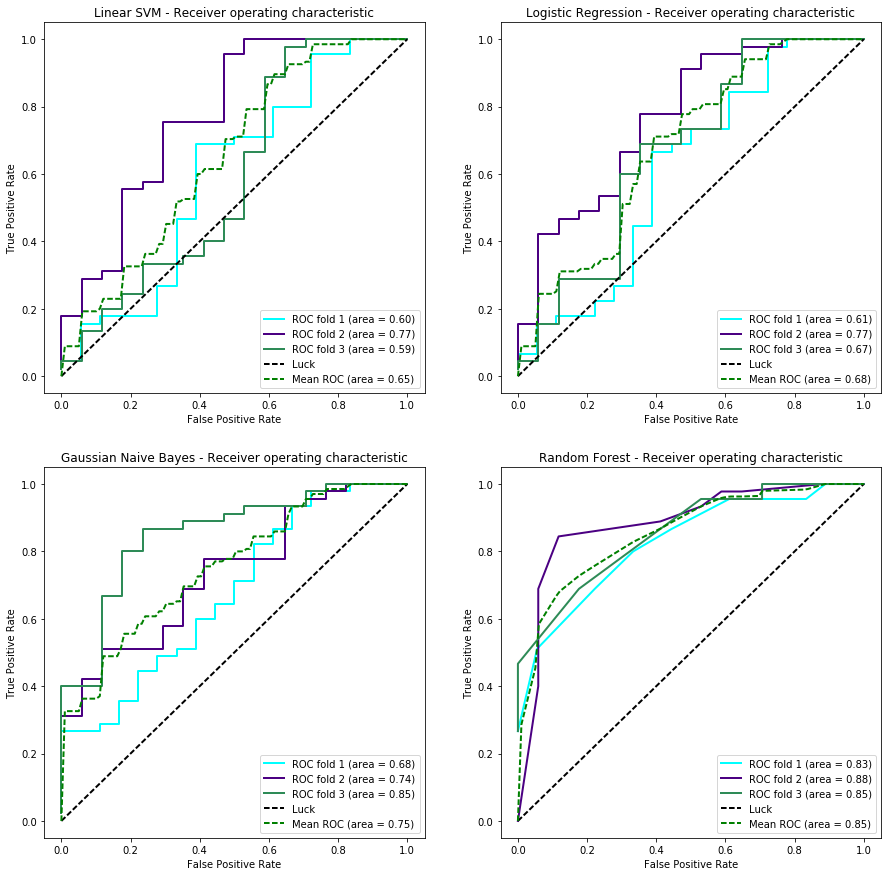

In [247]:
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)
clf0 = LogisticRegression()
clf1 = GaussianNB()
clf = RandomForestClassifier()

fig = plt.figure(figsize = (15,15))
plt.subplot(2, 2, 1)
ROC_Kfold(classifier,  clf_name='Linear SVM', show= False)
plt.subplot(2, 2, 2)
ROC_Kfold(clf0,  clf_name='Logistic Regression', show= False)
plt.subplot(2, 2, 3)
ROC_Kfold(clf1,  clf_name='Gaussian Naive Bayes', show= False)
plt.subplot(2, 2, 4)
ROC_Kfold(clf,  clf_name='Random Forest', show= False)

plt.show()

## Conclusion:
* From the ROC curves, logistics regression and linear SVM perform similary, giving AUC 0.65.
* Gaussian Naive Bayes: AUC= 0.75
* Random Forest: AUC = 0.85, might be overfitting

Again these test and training sets are not independent. So we need to interpret with caution these results with small sample sizes.



## Future work:
* Gait analysis: a few github reporistory for possible exploration:
https://github.com/Sage-Bionetworks/mhealthx/blob/master/mhealthx/extractors/pyGait.py
https://github.com/moorepants/Gait-Analysis-Toolkit

